# Superstore Dataset - Modelling and Regression

Goal is to see how profit is affected by different categories and aspects such as discount

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/superstore_cleaned.csv")

df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,sub_category,product_name,sales,quantity,discount,profit,order_year,order_month,ship_year,ship_month
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,11,2016,11
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,11,2016,11
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,6,2016,6
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,10,2015,10
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,10,2015,10


In [3]:
df.columns.tolist()


['row_id',
 'order_id',
 'order_date',
 'ship_date',
 'ship_mode',
 'customer_id',
 'customer_name',
 'segment',
 'country',
 'city',
 'state',
 'postal_code',
 'region',
 'product_id',
 'category',
 'sub_category',
 'product_name',
 'sales',
 'quantity',
 'discount',
 'profit',
 'order_year',
 'order_month',
 'ship_year',
 'ship_month']

**Research question:**  
Which factors most strongly influence profit at the order level in the Superstore dataset?

**Hypothesis:**  
Higher discounts are associated with lower profit, even when sales volume is high. Profitability will vary across product categories and customer segments.

This regression is used as an interpretable baseline model to support business decisions around discounting and product/segment strategy.

In [4]:
df["order_date"] = pd.to_datetime(df["order_date"])
df["ship_date"] = pd.to_datetime(df["ship_date"])

# Operational feature: shipping duration by days
df["ship_days"] = (df["ship_date"] - df["order_date"]).dt.days

df[["ship_days"]].describe()

,ship_days
count,9994.000000
mean,3.958175
std,1.747567
min,0.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,7.000000


## Feature Selection Rationale (LO3, LO9)

The model uses a small set of interpretable features:
- **discount** and **quantity**: pricing strategy and order size
- **sales**: scale of the order (often correlated with profit)
- **ship_days** and **ship_mode**: operational/logistics signal
- **segment, region, category**: business dimensions that influence purchasing behavior and margin

The goal is not maximum predictive accuracy, but a transparent baseline that supports decision-making.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Target
y = df["profit"]

# Features
numeric_features = ["sales", "quantity", "discount", "ship_days"]
categorical_features = ["segment", "region", "category", "ship_mode"]

X = df[numeric_features + categorical_features].copy()

# Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

mae, rmse, r2


(70.01248224848055, 291.1300104745578, -0.7480965897147589)

## Model Evaluation (LO3)

The regression model is evaluated using:
- **MAE (Mean Absolute Error):** average absolute prediction error (easy to interpret)
- **RMSE (Root Mean Squared Error):** penalizes larger errors more strongly
- **R²:** proportion of variance explained by the model

This baseline model prioritizes interpretability and business relevance rather than maximum performance.

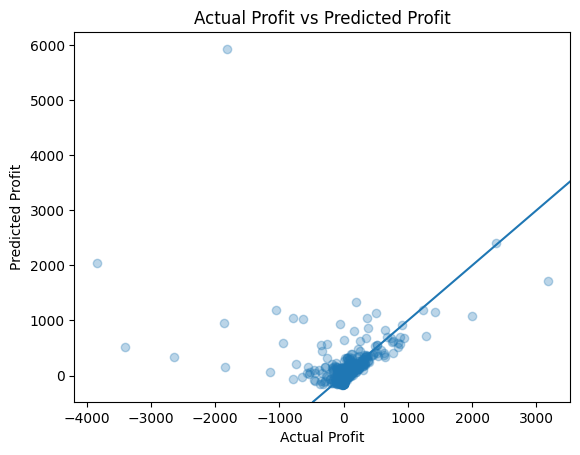

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title("Actual Profit vs Predicted Profit")
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.axline((0, 0), slope=1)
plt.show()

In [7]:
# Extract feature names after preprocessing
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names = list(cat_feature_names) + numeric_features

coefs = model.named_steps["regressor"].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})
coef_df = coef_df.reindex(coef_df["coefficient"].abs().sort_values(ascending=False).index)

coef_df.head(15)

,feature,coefficient
16,discount,-211.442466
7,category_Furniture,-35.091355
8,category_Office Supplies,29.524215
3,region_Central,8.885292
11,ship_mode_Same Day,7.982183
15,quantity,-6.861649
12,ship_mode_Second Class,-6.256684
9,category_Technology,5.567140
6,region_West,-4.760238
13,ship_mode_Standard Class,-4.537518


In [8]:
# Interpretation of Results

The coefficient table shows which variables are associated with higher or lower profit *holding other variables constant*.

Typical patterns to look for:
- A negative coefficient for discount suggests discounting is associated with reduced profit.
- Category/segment coefficients indicate systematic differences in margin across the business.
- If sales is positive but discount is negative, this supports the idea that “high sales can still be unprofitable if discounts are too aggressive.”

These insights can inform:
- Discount policy guardrails
- Category-level margin strategy
- Targeted segment offers rather than blanket discounting

SyntaxError: invalid character '“' (U+201C) (1253552881.py, line 8)

## Limitations and Alternative Approaches

**Limitations**
- Profit can be noisy at the individual order level and affected by factors not present in the dataset (costs, supplier pricing, returns).
- Linear regression assumes linear relationships and may not capture complex interactions (e.g., discount effects varying by category).

**Alternative approaches**
- Regularized regression (Ridge/Lasso) to reduce sensitivity to multicollinearity.
- Tree-based models (Random Forest / Gradient Boosting) to capture nonlinear patterns.
- Model per category to capture different margin structures.
- Time-based validation to avoid leakage when forecasting.

In [9]:
df.to_csv("../data/processed/superstore_model_ready.csv", index=False)
